<a href="https://colab.research.google.com/github/krsna-thecoder/CNN---DEEP-LEARNING/blob/main/four_qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane scikit-learn pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 42.3 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import fashion_mnist
from PIL import Image


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

# Binary classes: 0 (T-shirt), 1 (Trouser)
train_idx = np.where((y_train_raw == 0) | (y_train_raw == 1))
test_idx  = np.where((y_test_raw == 0) | (y_test_raw == 1))

x_train, y_train = x_train_raw[train_idx], y_train_raw[train_idx]
x_test, y_test   = x_test_raw[test_idx], y_test_raw[test_idx]

# Normalize
x_train = x_train.reshape(len(x_train), -1) / 255.0
x_test  = x_test.reshape(len(x_test), -1) / 255.0

# Label mapping: {0 → +1, 1 → -1}
y_train = np.where(y_train == 0, 1, -1)
y_test  = np.where(y_test == 0, 1, -1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ==============================
# 8. PCA (4 QUBITS)
# ==============================
N_QUBITS_4 = 4
pca_4 = PCA(n_components=N_QUBITS_4)

x_train_4 = pca_4.fit_transform(x_train)
x_test_4  = pca_4.transform(x_test)

xmin4, xmax4 = x_train_4.min(), x_train_4.max()
x_train_4 = 2 * (x_train_4 - xmin4) / (xmax4 - xmin4) - 1
x_test_4  = 2 * (x_test_4 - xmin4) / (xmax4 - xmin4) - 1


In [ ]:
dev4 = qml.device("default.qubit", wires=N_QUBITS_4)

@qml.qnode(dev4)
def qcnn_4(weights, x):
    for i in range(N_QUBITS_4):
        qml.RY(np.pi * x[i], wires=i)
        qml.RY(weights[i], wires=i)
    for i in range(N_QUBITS_4 - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))


In [ ]:
def qcnn_accuracy(weights, X, Y):
    preds = [1 if qcnn_4(weights, x) > 0 else -1 for x in X]
    return np.mean(np.array(preds) == Y)


In [ ]:
def loss_4(weights):
    loss = 0
    for i in range(50):
        pred = qcnn_4(weights, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 50

qcnn_acc_history = []

weights_4 = np.random.normal(0, 0.1, N_QUBITS_4, requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.05)

for epoch in range(40):
    weights_4 = opt.step(loss_4, weights_4)

    acc = qcnn_accuracy(
        weights_4,
        x_test_4[:50],
        y_test[:50]
    )

    qcnn_acc_history.append(acc)

    print(f"Epoch {epoch+1} | QCNN Accuracy: {acc:.3f}")

Epoch 1 | QCNN Accuracy: 0.440
Epoch 2 | QCNN Accuracy: 0.460
Epoch 3 | QCNN Accuracy: 0.460
Epoch 4 | QCNN Accuracy: 0.520
Epoch 5 | QCNN Accuracy: 0.600
Epoch 6 | QCNN Accuracy: 0.600
Epoch 7 | QCNN Accuracy: 0.620
Epoch 8 | QCNN Accuracy: 0.680
Epoch 9 | QCNN Accuracy: 0.700
Epoch 10 | QCNN Accuracy: 0.720
Epoch 11 | QCNN Accuracy: 0.760
Epoch 12 | QCNN Accuracy: 0.820
Epoch 13 | QCNN Accuracy: 0.840
Epoch 14 | QCNN Accuracy: 0.840
Epoch 15 | QCNN Accuracy: 0.840
Epoch 16 | QCNN Accuracy: 0.840
Epoch 17 | QCNN Accuracy: 0.840
Epoch 18 | QCNN Accuracy: 0.840
Epoch 19 | QCNN Accuracy: 0.820
Epoch 20 | QCNN Accuracy: 0.840
Epoch 21 | QCNN Accuracy: 0.840
Epoch 22 | QCNN Accuracy: 0.820
Epoch 23 | QCNN Accuracy: 0.820
Epoch 24 | QCNN Accuracy: 0.820
Epoch 25 | QCNN Accuracy: 0.800
Epoch 26 | QCNN Accuracy: 0.820
Epoch 27 | QCNN Accuracy: 0.820
Epoch 28 | QCNN Accuracy: 0.820
Epoch 29 | QCNN Accuracy: 0.820
Epoch 30 | QCNN Accuracy: 0.820
Epoch 31 | QCNN Accuracy: 0.820
Epoch 32 | QCNN A

In [ ]:

def accuracy_4(weights, X, Y):
    preds = [1 if qcnn_4(weights, x) > 0 else -1 for x in X]
    return np.mean(np.array(preds) == Y)

print("4-Qubit Test Accuracy:", accuracy_4(weights_4, x_test_4[:50], y_test[:50]))


4-Qubit Test Accuracy: 0.82


In [ ]:

preds = [qcnn_4(weights_4, x) for x in x_test_4[:50]]
print(preds)


[tensor(-0.79054727, requires_grad=True), tensor(-0.99425865, requires_grad=True), tensor(-0.44396502, requires_grad=True), tensor(-0.92311688, requires_grad=True), tensor(0.91785596, requires_grad=True), tensor(-0.98445693, requires_grad=True), tensor(0.9283352, requires_grad=True), tensor(-0.28260547, requires_grad=True), tensor(-0.84119643, requires_grad=True), tensor(-0.71859877, requires_grad=True), tensor(-0.56093887, requires_grad=True), tensor(-0.76405126, requires_grad=True), tensor(-0.99876725, requires_grad=True), tensor(-0.80748905, requires_grad=True), tensor(-0.73464418, requires_grad=True), tensor(-0.99074547, requires_grad=True), tensor(0.98605126, requires_grad=True), tensor(0.99982562, requires_grad=True), tensor(-0.92378511, requires_grad=True), tensor(-0.38855434, requires_grad=True), tensor(-0.83220916, requires_grad=True), tensor(0.92689029, requires_grad=True), tensor(0.73738937, requires_grad=True), tensor(0.549458, requires_grad=True), tensor(0.91444431, requir

In [ ]:
# checking for class wise accuracy
def class_wise_accuracy_4(weights, X, Y):
    results = {}
    for label in [1, -1]:  # 1 = T-shirt, -1 = Trouser
        idx = [i for i in range(len(Y)) if Y[i] == label]
        correct = 0
        for i in idx:
            pred = 1 if qcnn_4(weights, X[i]) > 0 else -1
            if pred == Y[i]:
                correct += 1
        results[label] = correct / len(idx)
    return results

acc = class_wise_accuracy_4(weights_4, x_test_4[:50], y_test[:50])
print("T-shirt accuracy:", acc[1])
print("Trouser accuracy:", acc[-1])


T-shirt accuracy: 0.6818181818181818
Trouser accuracy: 0.9285714285714286


In [ ]:
# checking for confusion matrix
def confusion_matrix_4(weights, X, Y):
    TP = TN = FP = FN = 0
    for x, y in zip(X, Y):
        pred = 1 if qcnn_4(weights, x) > 0 else -1
        if y == 1 and pred == 1: TP += 1
        if y == -1 and pred == -1: TN += 1
        if y == -1 and pred == 1: FP += 1
        if y == 1 and pred == -1: FN += 1
    return TP, FP, FN, TN

TP, FP, FN, TN = confusion_matrix_4(weights_4, x_test_4[:50], y_test[:50])
print("Confusion Matrix")
print("TP:", TP, "FP:", FP)
print("FN:", FN, "TN:", TN)


Confusion Matrix
TP: 15 FP: 2
FN: 7 TN: 26


In [ ]:
#checking for accuracy vs confidence
def accuracy_with_threshold_4(weights, X, Y, threshold):
    correct = 0
    count = 0
    for x, y in zip(X, Y):
        val = qcnn_4(weights, x)
        if abs(val) >= threshold:  # only confident predictions
            pred = 1 if val > 0 else -1
            correct += (pred == y)
            count += 1
    return correct / count if count > 0 else None

for t in [0.0, 0.3, 0.6]:
    acc = accuracy_with_threshold_4(weights_4, x_test_4[:50], y_test[:50], t)
    print(f"Accuracy for |output| ≥ {t}:", acc)


Accuracy for |output| ≥ 0.0: 0.82
Accuracy for |output| ≥ 0.3: 0.8666666666666667
Accuracy for |output| ≥ 0.6: 0.9459459459459459


In [ ]:
#checking for utput distribution
outputs = [float(qcnn_4(weights_4, x)) for x in x_test_4[:50]]

print("Mean output:", np.mean(outputs))
print("Std output :", np.std(outputs))
print("Min, Max  :", min(outputs), max(outputs))


Mean output: -0.2721492637021104
Std output : 0.7318704416470606
Min, Max  : -0.9987672497778709 0.9998256248267057


now greating a hybrid model by using quantum convolution layer+classical neural network for learning

In [ ]:
dev_hybrid = qml.device("default.qubit", wires=N_QUBITS_4)

@qml.qnode(dev_hybrid)
def quantum_filter(weights, x):

    for i in range(N_QUBITS_4):
        qml.RY(np.pi * x[i], wires=i)


    for i in range(N_QUBITS_4):
        qml.RY(weights[i], wires=i)

    for i in range(N_QUBITS_4 - 1):
        qml.CNOT(wires=[i, i + 1])


    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_4)]


In [ ]:
#creating a head
def classical_head(params, q_features):
    W1, b1, W2, b2 = params
    h = np.tanh(np.dot(q_features, W1) + b1)
    out = np.dot(h, W2) + b2
    return out[0]


In [ ]:
def hybrid_forward(weights_q, weights_c, x):
    q_out = quantum_filter(weights_q, x)
    return classical_head(weights_c, np.array(q_out))


In [ ]:
def hybrid_loss(weights_q, weights_c):
    loss = 0
    for i in range(200):
        pred = hybrid_forward(weights_q, weights_c, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 200


In [ ]:
weights_q = np.random.normal(0, 0.1, N_QUBITS_4, requires_grad=True)

W1 = np.random.normal(0, 0.2, (N_QUBITS_4, 8), requires_grad=True)
b1 = np.zeros(8, requires_grad=True)
W2 = np.random.normal(0, 0.2, (8, 1), requires_grad=True)
b2 = np.zeros(1, requires_grad=True)

weights_c = [W1, b1, W2, b2]


In [ ]:
hybrid_acc_history = []


In [ ]:
opt = qml.AdamOptimizer(0.02)

for epoch in range(40):
    weights_q, weights_c = opt.step(
        lambda *args: hybrid_loss(args[0], args[1]),
        weights_q, weights_c
    )

    acc = np.mean([
        np.sign(hybrid_forward(weights_q, weights_c, x_test_4[i])) == y_test[i]
        for i in range(50)
    ])

    hybrid_acc_history.append(acc)

    print(f"Epoch {epoch+1} | Hybrid (1 filter) Accuracy: {acc:.3f}")


Epoch 1 | Hybrid (1 filter) Accuracy: 0.660
Epoch 2 | Hybrid (1 filter) Accuracy: 0.680
Epoch 3 | Hybrid (1 filter) Accuracy: 0.680
Epoch 4 | Hybrid (1 filter) Accuracy: 0.680
Epoch 5 | Hybrid (1 filter) Accuracy: 0.700
Epoch 6 | Hybrid (1 filter) Accuracy: 0.700
Epoch 7 | Hybrid (1 filter) Accuracy: 0.740
Epoch 8 | Hybrid (1 filter) Accuracy: 0.760
Epoch 9 | Hybrid (1 filter) Accuracy: 0.800
Epoch 10 | Hybrid (1 filter) Accuracy: 0.820
Epoch 11 | Hybrid (1 filter) Accuracy: 0.820
Epoch 12 | Hybrid (1 filter) Accuracy: 0.820
Epoch 13 | Hybrid (1 filter) Accuracy: 0.840
Epoch 14 | Hybrid (1 filter) Accuracy: 0.840
Epoch 15 | Hybrid (1 filter) Accuracy: 0.840
Epoch 16 | Hybrid (1 filter) Accuracy: 0.820
Epoch 17 | Hybrid (1 filter) Accuracy: 0.840
Epoch 18 | Hybrid (1 filter) Accuracy: 0.860
Epoch 19 | Hybrid (1 filter) Accuracy: 0.860
Epoch 20 | Hybrid (1 filter) Accuracy: 0.860
Epoch 21 | Hybrid (1 filter) Accuracy: 0.880
Epoch 22 | Hybrid (1 filter) Accuracy: 0.880
Epoch 23 | Hybrid (

In [ ]:
#calculating the accuracy for the hybrid model
def hybrid_accuracy(weights_q, weights_c, X, Y):
    preds = []
    for x in X:
        val = hybrid_forward(weights_q, weights_c, x)
        preds.append(1 if val > 0 else -1)
    return np.mean(np.array(preds) == Y)

In [ ]:

print("Hybrid Test Accuracy:",
      hybrid_accuracy(weights_q, weights_c, x_test_4[:50], y_test[:50]))

Hybrid Test Accuracy: 0.96


In [ ]:
hybrid_preds = [hybrid_forward(weights_q, weights_c, x)
                for x in x_test_4[:50]]

print(hybrid_preds)

[tensor(-0.37088569, requires_grad=True), tensor(-0.18291391, requires_grad=True), tensor(-0.34266637, requires_grad=True), tensor(-0.24690657, requires_grad=True), tensor(0.27197697, requires_grad=True), tensor(-0.21307223, requires_grad=True), tensor(0.02438489, requires_grad=True), tensor(0.24192065, requires_grad=True), tensor(-0.38966344, requires_grad=True), tensor(-0.39596674, requires_grad=True), tensor(0.26563567, requires_grad=True), tensor(-0.34349914, requires_grad=True), tensor(-0.01915066, requires_grad=True), tensor(0.26289018, requires_grad=True), tensor(-0.38976865, requires_grad=True), tensor(0.06484367, requires_grad=True), tensor(0.23520619, requires_grad=True), tensor(0.15723679, requires_grad=True), tensor(-0.3408909, requires_grad=True), tensor(0.2467453, requires_grad=True), tensor(-0.31820389, requires_grad=True), tensor(0.15072316, requires_grad=True), tensor(0.00727717, requires_grad=True), tensor(0.32699279, requires_grad=True), tensor(0.22017606, requires_g

In [ ]:
import matplotlib.pyplot as plt


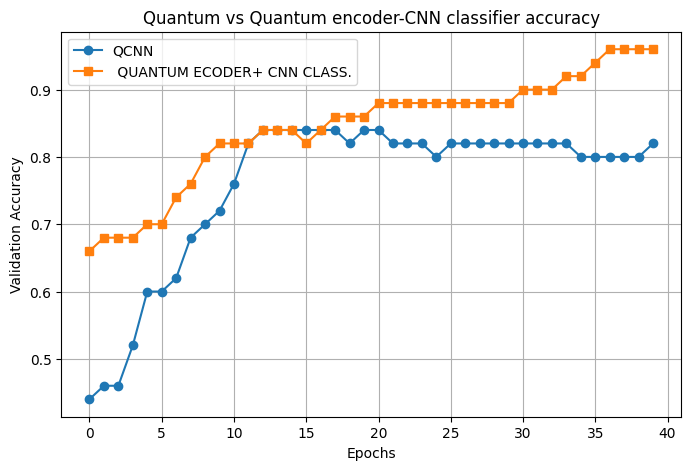

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(qcnn_acc_history, label="QCNN", marker='o')
plt.plot(hybrid_acc_history, label=" QUANTUM ECODER+ CNN CLASS.", marker='s')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Quantum vs Quantum encoder-CNN classifier accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [50]:
# ==============================
# MULTI-FILTER HYBRID MODEL
# ==============================

N_FILTERS = 3  # We will use 3 parallel quantum filters

# 1. Initialize Quantum Weights for 3 filters
# Shape: (3 filters, 4 qubits)
weights_q_multi = np.random.normal(0, 0.1, (N_FILTERS, N_QUBITS_4), requires_grad=True)

# 2. Initialize Classical Weights
# Input dimension is now 4 qubits * 3 filters = 12 features
INPUT_DIM_MULTI = N_QUBITS_4 * N_FILTERS

W1_multi = np.random.normal(0, 0.2, (INPUT_DIM_MULTI, 8), requires_grad=True)
b1_multi = np.zeros(8, requires_grad=True)
W2_multi = np.random.normal(0, 0.2, (8, 1), requires_grad=True)
b2_multi = np.zeros(1, requires_grad=True)

weights_c_multi = [W1_multi, b1_multi, W2_multi, b2_multi]

print("Weights initialized for Multi-Filter Hybrid Model.")

Weights initialized for Multi-Filter Hybrid Model.


In [51]:
def hybrid_multi_forward(weights_q_multi, weights_c_multi, x):
    # Run the quantum circuit 3 times with different weights
    # specific to each filter
    features = []

    for i in range(N_FILTERS):
        # Use the i-th set of quantum weights
        # We reuse the 'quantum_filter' function you already defined!
        q_out = quantum_filter(weights_q_multi[i], x)
        features.extend(q_out)

    # Flatten features to a single vector of size 12
    features = np.array(features)

    # Pass to the classical head (this works because we resized W1_multi)
    return classical_head(weights_c_multi, features)

def hybrid_multi_loss(weights_q_multi, weights_c_multi):
    loss = 0
    # Training on the same subset of 200 samples
    for i in range(200):
        pred = hybrid_multi_forward(weights_q_multi, weights_c_multi, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 200

In [52]:
multi_hybrid_acc_history = []
opt = qml.AdamOptimizer(0.02)

print("Starting Multi-Filter Training...")

for epoch in range(40):
    # Optimization step
    weights_q_multi, weights_c_multi = opt.step(
        lambda q, c: hybrid_multi_loss(q, c),
        weights_q_multi,
        weights_c_multi
    )

    # Calculate Accuracy on Test Set (first 50 samples)
    acc = np.mean([
        np.sign(hybrid_multi_forward(weights_q_multi, weights_c_multi, x_test_4[i]))
        == y_test[i]
        for i in range(50)
    ])

    multi_hybrid_acc_history.append(acc)

    print(f"Epoch {epoch+1} | Hybrid (3 Filters) Accuracy: {acc:.3f}")

Starting Multi-Filter Training...
Epoch 1 | Hybrid (3 Filters) Accuracy: 0.620
Epoch 2 | Hybrid (3 Filters) Accuracy: 0.640
Epoch 3 | Hybrid (3 Filters) Accuracy: 0.660
Epoch 4 | Hybrid (3 Filters) Accuracy: 0.700
Epoch 5 | Hybrid (3 Filters) Accuracy: 0.700
Epoch 6 | Hybrid (3 Filters) Accuracy: 0.700
Epoch 7 | Hybrid (3 Filters) Accuracy: 0.720
Epoch 8 | Hybrid (3 Filters) Accuracy: 0.720
Epoch 9 | Hybrid (3 Filters) Accuracy: 0.720
Epoch 10 | Hybrid (3 Filters) Accuracy: 0.720
Epoch 11 | Hybrid (3 Filters) Accuracy: 0.740
Epoch 12 | Hybrid (3 Filters) Accuracy: 0.740
Epoch 13 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 14 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 15 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 16 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 17 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 18 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 19 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 20 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 21 | Hybrid (3 Filters) Accuracy: 0.760
Epoch 22 

In [53]:
# Calculating the accuracy for the multi-filter hybrid model
def hybrid_multi_accuracy(weights_q_multi, weights_c_multi, X, Y):
    preds = []
    for x in X:
        val = hybrid_multi_forward(weights_q_multi, weights_c_multi, x)
        preds.append(1 if val > 0 else -1)
    return np.mean(np.array(preds) == Y)

print("Hybrid (Multi-Filter) Test Accuracy:",
      hybrid_multi_accuracy(weights_q_multi, weights_c_multi, x_test_4[:50], y_test[:50]))

Hybrid (Multi-Filter) Test Accuracy: 0.96


In [54]:
hybrid_multi_preds = [hybrid_multi_forward(weights_q_multi, weights_c_multi, x)
                      for x in x_test_4[:50]]

print(hybrid_multi_preds)

[tensor(-0.44208386, requires_grad=True), tensor(-0.16571832, requires_grad=True), tensor(-0.28071312, requires_grad=True), tensor(-0.17313178, requires_grad=True), tensor(0.21421139, requires_grad=True), tensor(-0.19102069, requires_grad=True), tensor(0.1161433, requires_grad=True), tensor(0.06529707, requires_grad=True), tensor(-0.46504079, requires_grad=True), tensor(-0.36322421, requires_grad=True), tensor(0.0782094, requires_grad=True), tensor(-0.44000506, requires_grad=True), tensor(-0.0112266, requires_grad=True), tensor(0.06880435, requires_grad=True), tensor(-0.41712292, requires_grad=True), tensor(0.02371252, requires_grad=True), tensor(0.21303516, requires_grad=True), tensor(0.14485047, requires_grad=True), tensor(-0.35639398, requires_grad=True), tensor(0.05550671, requires_grad=True), tensor(-0.23209831, requires_grad=True), tensor(0.10545437, requires_grad=True), tensor(0.00145985, requires_grad=True), tensor(0.22418132, requires_grad=True), tensor(0.14585719, requires_gr

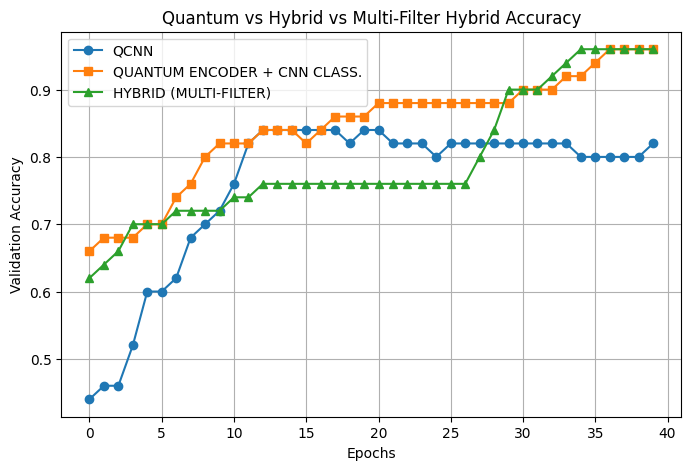

In [55]:
plt.figure(figsize=(8,5))

# 1. Pure Quantum CNN
plt.plot(qcnn_acc_history, label="QCNN", marker='o')

# 2. Hybrid (Single Filter)
plt.plot(hybrid_acc_history, label="QUANTUM ENCODER + CNN CLASS.", marker='s')

# 3. Hybrid (Multiple Filters) - NEW ADDITION
plt.plot(multi_hybrid_acc_history, label="HYBRID (MULTI-FILTER)", marker='^')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Quantum vs Hybrid vs Multi-Filter Hybrid Accuracy")
plt.legend()
plt.grid(True)

plt.show()